# Purpose

This is a demonstration of building a recommender system for movies based on ratings. Now to load the example data and the needed libraries.

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline


moviesRates = loadmat("C:\\Users\\CoreySSD\\Downloads\\ex8_movies.mat") # Ratings of each of the movies
moviesFets = loadmat("C:\\Users\\CoreySSD\\Downloads\\ex8_movieParams.mat") # Features of the movies
movieList = open("C:\\Users\\CoreySSD\\Downloads\\movie_ids.txt","r").read().split("\n")[:-1] # Movie titles

Y = moviesRates["Y"] # 1682 X 943 matrix, containing ratings (1-5) of 1,682 movies from 943 users
R = moviesRates["R"] # 1682 X 943 matrix, where R(i,j) = 1 if and only if user j give rating to movie i

X = moviesFets["X"] # 1682 X 10 matrix , num_movies X num_features matrix of movie features
Theta = moviesFets["Theta"] # 943 X 10 matrix, num_users X num_features matrix of user features

Let's just take a quick look at some of the movies that are in the data.

In [2]:
print(movieList[:5])

['1 Toy Story (1995)', '2 GoldenEye (1995)', '3 Four Rooms (1995)', '4 Get Shorty (1995)', '5 Copycat (1995)']


Ignore the value in front of the movie title, this will be handled later on. Now there is nothing really to do but to start programming the cost function and gradient.

In [3]:
def  cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering problem
    """
    
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    # Computing the regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Computing the gradient
    X_grad = err * R @ Theta
    Theta_grad = (err * R).T @ X
    grad = np.append(X_grad.flatten(), Theta_grad.flatten())
    
    # Computing the regularized gradient
    reg_X_grad = X_grad + Lambda * X
    reg_Theta_grad = Theta_grad + Lambda * Theta
    reg_grad = np.append(reg_X_grad.flatten(), reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

I will randomly rate some movies as a 'new user' to this system.

In [4]:
# Initialize my ratings
my_ratings = np.zeros((1682,1))

# Creating some random ratings for myself
my_ratings[1] = 4 
my_ratings[789] = 2
my_ratings[6] = 3
my_ratings[4]= 5
my_ratings[54] = 4
my_ratings[78]= 5
my_ratings[3]= 3
my_ratings[654] = 5
my_ratings[67]= 4
my_ratings[54] = 5
my_ratings[8]= 5

# Let's see what I rated randomly
print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated", int(my_ratings[i]), "for index", movieList[i])

New user ratings:

Rated 4 for index 2 GoldenEye (1995)
Rated 3 for index 4 Get Shorty (1995)
Rated 5 for index 5 Copycat (1995)
Rated 3 for index 7 Twelve Monkeys (1995)
Rated 5 for index 9 Dead Man Walking (1995)
Rated 5 for index 55 Professional, The (1994)
Rated 4 for index 68 Crow, The (1994)
Rated 5 for index 79 Fugitive, The (1993)
Rated 5 for index 655 Stand by Me (1986)
Rated 2 for index 790 Tommy Boy (1995)


The next cell will create a function to normalize the ratings, and the other will conduct batch gradient descent.

In [5]:
def normalizeRatings(Y, R):
    """
    normalized Y so that each movie has a rating of 0 on average, and returns the mean rating in Ymean.
    """
    
    m, n = Y.shape[0], Y.shape[1]
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros((m,n))
    
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:]) / np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:] == 1] = Y[i,R[i,:] == 1] - Ymean[i]
        
    return Ynorm, Ymean

def gradientDescent(initial_parameters, Y, R, num_users, num_movies, num_features, alpha, num_iters, Lambda):
    """
    Optimize X and Theta
    """
    # Unfolding the parameters
    X = initial_parameters[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = initial_parameters[num_movies * num_features:].reshape(num_users, num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        params = np.append(X.flatten(), Theta.flatten())
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies * num_features].reshape(num_movies, num_features)
        Theta_grad = grad[num_movies * num_features:].reshape(num_users, num_features)
        X = X - (alpha * X_grad)
        Theta = Theta - (alpha * Theta_grad)
        J_history.append(cost)
    
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

In [6]:
Y = np.hstack((my_ratings,Y))
R = np.hstack((my_ratings != 0, R))

# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set initial Parameters (Theta,X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.append(X.flatten(),Theta.flatten())
Lambda = 10

# Optimize parameters using Gradient Descent
paramsFinal, J_history = gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,0.001,400,Lambda)

For a sanity check, I will graph the cost function to ensure the gradient descent algorithm is working properly.

Text(0.5,1,'Cost function using Gradient Descent')

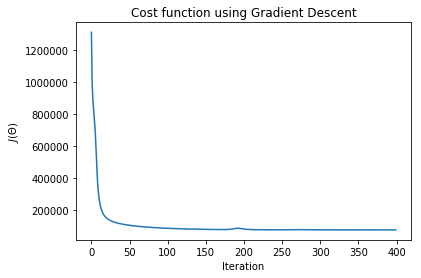

In [7]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

Excellent, the algorithm learned and was able to decrease the cost associated with the $\theta$s. Next is to make predictions that have not been rated yet. Since the ratings were normalized, I will add the mean back to the value to produce a correct un-normalized predicted rating.

In [8]:
# unfold paramaters
X = paramsFinal[:num_movies*num_features].reshape(num_movies,num_features)
Theta = paramsFinal[num_movies*num_features:].reshape(num_users,num_features)

# Predict rating
p = X @ Theta.T
my_predictions = p[:,0][:,np.newaxis] + Ymean

df = pd.DataFrame(np.hstack((my_predictions, np.array(movieList)[:,np.newaxis])))
df.sort_values(by=[0], ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Top recommendations for you:\n")
for i in range(10):
    print("Predicting rating",round(float(df[0][i]),1)," for index",df[1][i])

Top recommendations for you:

Predicting rating 8.7  for index 64 Shawshank Redemption, The (1994)
Predicting rating 8.7  for index 313 Titanic (1997)
Predicting rating 8.6  for index 318 Schindler's List (1993)
Predicting rating 8.6  for index 272 Good Will Hunting (1997)
Predicting rating 8.4  for index 12 Usual Suspects, The (1995)
Predicting rating 8.4  for index 127 Godfather, The (1972)
Predicting rating 8.4  for index 408 Close Shave, A (1995)
Predicting rating 8.3  for index 169 Wrong Trousers, The (1993)
Predicting rating 8.3  for index 483 Casablanca (1942)
Predicting rating 8.3  for index 302 L.A. Confidential (1997)


Not bad recommendations given my randomly assigned ratings.